# Comparison with EventDisplay

**Purpose of this notebook:**

Compare IRF and Sensitivity as computed by pyirf and EventDisplay on the same DL2 results

**Notes:**

The following results correspond to:

- Paranal site
- Zd 20 deg, Az 180 deg
- 50 h observation time

**Resources:**

_EventDisplay_ DL2 data, https://forge.in2p3.fr/projects/cta_analysis-and-simulations/wiki/Eventdisplay_Prod3b_DL2_Lists


Download and unpack the data using 

```bash
$ curl -fL -o data.zip https://nextcloud.e5.physik.tu-dortmund.de/index.php/s/Cstsf8MWZjnz92L/download
$ unzip data.zip
$ mv eventdisplay_dl2 data
```

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports

In [5]:
import os

import numpy as np
import uproot
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable
from matplotlib.ticker import ScalarFormatter

from pyirf.binning import bin_center

%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = (9, 6)

## Input data

### _EventDisplay_

The input data provided by _EventDisplay_ is stored in _ROOT_ format, so _uproot_ is used to transform it into _numpy_ objects. 

## _pyirf_

The following is the current IRF + sensititivy output FITS format provided by this software.

Run `python examples/calculate_eventdisplay_irfs.py` after downloading the data

In [7]:
indir = "../pyirf_data/"

In [8]:
# irf_file_event_display = "DESY.g20210921.V3.ID0.prod5-Paranal-20deg-sq10-LL.S-M6C5-14MSTs40SSTs-MSTF.180000s.root"
# irf_eventdisplay = uproot.open(os.path.join(indir, irf_file_event_display))
# my_pyirf_file = indir + 'M6C5-14MSTs40SSTs-MSTF_1bin_pyirf_eventdisplay.fits.gz'
# pyirf_file_event_type_1 = indir + 'M6C5-14MSTs40SSTs-MSTF_1bin_event_type_1.fits.gz'
# pyirf_file_event_type_2 = indir + 'M6C5-14MSTs40SSTs-MSTF_1bin_event_type_2.fits.gz'
# pyirf_file_event_type_3 = indir + 'M6C5-14MSTs40SSTs-MSTF_1bin_event_type_3.fits.gz'

In [9]:
irf_file_event_display = "DESY.g20210921.V3.ID0.prod5-Paranal-20deg-sq10-LL.S-M6C5-14MSTs40SSTs-MSTF.180000s.root"
irf_eventdisplay = uproot.open(os.path.join(indir, irf_file_event_display))
my_pyirf_file = indir + 'M6C5-14MSTs40SSTs-MSTF_pyirf_eventdisplay.fits.gz'
pyirf_file_event_type_1 = indir + 'M6C5-14MSTs40SSTs-MSTF_event_type_1.fits.gz'
pyirf_file_event_type_2 = indir + 'M6C5-14MSTs40SSTs-MSTF_event_type_2.fits.gz'
pyirf_file_event_type_3 = indir + 'M6C5-14MSTs40SSTs-MSTF_event_type_3.fits.gz'

In [10]:
# irf_file_event_display = "DESY.d20180113.V3.ID0NIM2LST4MST4SST4SCMST4.prod3b-paranal20degs05b-NN.S.3HB9-FD.180000s.root"
# irf_eventdisplay = uproot.open(os.path.join(indir, irf_file_event_display))
# my_pyirf_file = indir + '4LSTs25MSTs70SSTs-MSTF_pyirf_eventdisplay.fits.gz'
# pyirf_file_event_type_1 = indir + '4LSTs25MSTs70SSTs-MSTF_event_type_1.fits.gz'
# pyirf_file_event_type_2 = indir + '4LSTs25MSTs70SSTs-MSTF_event_type_2.fits.gz'
# pyirf_file_event_type_3 = indir + '4LSTs25MSTs70SSTs-MSTF_event_type_3.fits.gz'

In [11]:
# irf_file_event_display = 'DESY.g20201203.V3.ID0NIM3LST3MST3SST3SCMST3.prod5b-LaPalma-20deg-sq10-LL.N.D25-4LSTs09MSTs-MSTN.180000s.root'
# irf_eventdisplay = uproot.open(os.path.join(indir, irf_file_event_display))
# my_pyirf_file = indir + 'D25-4LSTs09MSTs-MSTN_pyirf_eventdisplay.fits.gz'
# pyirf_file_event_type_1 = indir + 'D25-4LSTs09MSTs-MSTN_event_type_1.fits.gz'
# pyirf_file_event_type_2 = indir + 'D25-4LSTs09MSTs-MSTN_event_type_2.fits.gz'
# pyirf_file_event_type_3 = indir + 'D25-4LSTs09MSTs-MSTN_event_type_3.fits.gz'

## Optimized cuts
[back to top](#Table-of-contents)

### Direction cut
[back to top](#Table-of-contents)

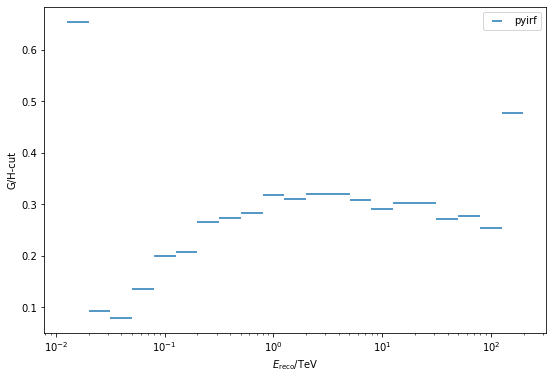

In [12]:
from astropy.table import QTable


gh_cut = QTable.read(pyirf_file_event_type_1, hdu='GH_CUTS')[1:-1]


plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='pyirf',
)

plt.legend()
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')

None # to remove clutter by mpl objects

## Differential sensitivity from cuts optimization
[back to top](#Table-of-contents)

In [13]:
def calculate_and_format_sensitivity(pyirf_file):
    # [1:-1] removes under/overflow bins
    sensitivity = QTable.read(pyirf_file, hdu='SENSITIVITY')[1:-1]

    # make it print nice
    sensitivity['reco_energy_low'].info.format = '.3g'
    sensitivity['reco_energy_high'].info.format = '.3g'
    sensitivity['reco_energy_center'].info.format = '.3g'
    sensitivity['relative_sensitivity'].info.format = '.2g'
    sensitivity['flux_sensitivity'].info.format = '.3g'

    for k in filter(lambda k: k.startswith('n_'), sensitivity.colnames):
        sensitivity[k].info.format = '.1f'

    return sensitivity

In [14]:
sensitivity_alltypes = calculate_and_format_sensitivity(my_pyirf_file)
sensitivity_type1 = calculate_and_format_sensitivity(pyirf_file_event_type_1)
sensitivity_type2 = calculate_and_format_sensitivity(pyirf_file_event_type_2)
sensitivity_type3 = calculate_and_format_sensitivity(pyirf_file_event_type_3)
sensitivity_type1

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,n_electron,n_electron_weighted,n_proton,n_proton_weighted,significance,relative_sensitivity,flux_sensitivity
TeV,TeV,TeV,,,,,,,,,,,1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0126,0.02,0.0163,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,nan,inf,inf
0.02,0.0316,0.0258,20.1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,5.986250026900071,0.84,3.44e-07
0.0316,0.0501,0.0409,1595.4,600.9,170.9,59018.6,20.2,1578.7,150.7,57439.9,4.999999999998908,0.09,1.11e-08
0.0501,0.0794,0.0648,2016.2,599.8,357.9,58799.4,209.7,11995.9,148.2,46803.6,4.99999999999892,0.01,3.67e-10
0.0794,0.126,0.103,1276.1,282.0,164.1,12712.9,134.4,4942.3,29.7,7770.7,5.000000000000239,0.0064,7.06e-11
0.126,0.2,0.163,931.5,155.8,75.5,3751.8,65.4,1557.5,10.1,2194.4,5.000000000001023,0.0057,1.87e-11
0.2,0.316,0.258,624.6,78.3,36.6,876.6,34.7,532.3,1.9,344.4,5.0000000001093,0.005,4.93e-12
0.316,0.501,0.409,582.3,53.6,27.6,380.8,26.6,244.4,1.0,136.3,4.9999999997422835,0.0047,1.37e-12


[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.3855742e-12
 9.2347094e-13 5.5671586e-13 3.5767754e-13 2.5445986e-13 1.8094634e-13
 1.2870316e-13 1.0036748e-13 9.1525718e-14 8.4259951e-14 9.4946932e-14
 9.2391935e-14 1.3596843e-13 1.7604817e-13 2.7765913e-13 3.6780136e-13
 0.0000000e+00]
inf / 0.0 = inf
4.503519440669422e-10 / 0.0 = inf
2.8086269459205926e-11 / 0.0 = inf
2.694119352906004e-12 / 0.0 = inf
8.957606657785637e-13 / 3.385574156092308e-12 = 0.26458161141342923
5.595640589747622e-13 / 9.234709351380044e-13 = 0.6059357557269959
3.6572617648745246e-13 / 5.567158604773137e-13 = 0.6569350766724849
2.6221301124029427e-13 / 3.5767753776144717e-13 = 0.7330989049001368
1.933824882435817e-13 / 2.544598646375684e-13 = 0.7599724558488613
1.426642160676754e-13 / 1.80946335931291e-13 = 0.7884338488171869
1.1530964614836764e-13 / 1.2870315978328467e-13 = 0.8959348499487538
1.0204463623951993e-13 / 1.0036748179526739e-13 = 1.0167101377284093
1.0622267588444277e-13 / 9.15257182109

/home/thassan/Paquetes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/thassan/Paquetes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


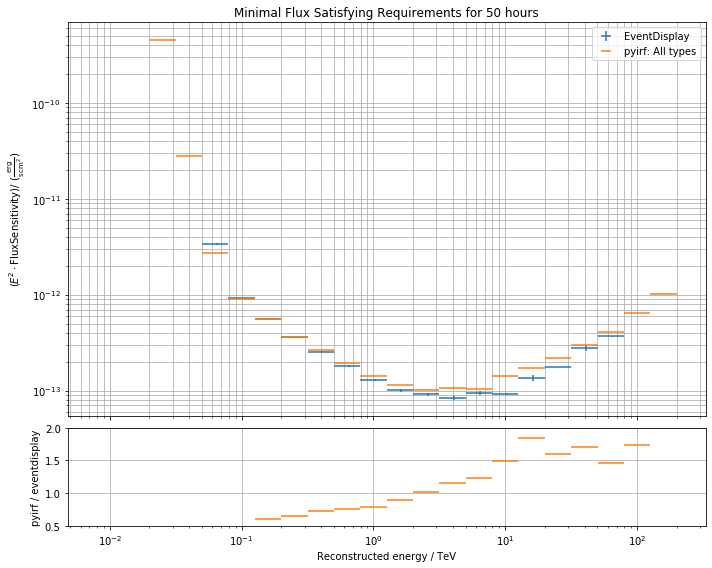

In [10]:
# Get data from event display file
y, edges = irf_eventdisplay["DiffSens"].to_numpy()
yerr = irf_eventdisplay["DiffSens"].errors()
bins = 10**edges
x = bin_center(bins)
width = np.diff(bins)

fig, (ax_sens, ax_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [4, 1]},
    sharex=True, figsize=(10,8)
)

ax_sens.errorbar(
    x,
    y, 
    xerr=width/2,
    yerr=yerr,
    label="EventDisplay",
    ls=''
)

unit = u.Unit('erg cm-2 s-1')

print(y)
def plot_sensitivity(sensitivity, axis, axis_ratio, label, y, color):
    
    e = sensitivity['reco_energy_center']
    w = (sensitivity['reco_energy_high'] - sensitivity['reco_energy_low'])
    s = (e**2 * sensitivity['flux_sensitivity'])


    axis.errorbar(
        e.to_value(u.TeV),
        s.to_value(unit),
        xerr=w.to_value(u.TeV) / 2,
        ls='',
        color=color,
        label=label
    )
    ratios = s.to_value(unit)/y
    for i, y1 in enumerate(s.to_value(unit)):
        print("{} / {} = {}".format(y1, y[i], ratios[i]))
    ax_ratio.errorbar(
        e.to_value(u.TeV), s.to_value(unit) / y,
        xerr=w.to_value(u.TeV)/2,
        color=color,
        ls=''
    )
    
plot_sensitivity(sensitivity_alltypes, ax_sens, ax_ratio, "pyirf: All types", y, "C1")

# ax_ratio.set_yscale('log')
ax_ratio.set_xlabel("Reconstructed energy / TeV")
ax_ratio.set_ylabel('pyirf / eventdisplay')
ax_ratio.grid()
ax_ratio.yaxis.set_major_formatter(ScalarFormatter())

ax_ratio.set_ylim(0.5, 2.0)
# ax_ratio.set_yticks([0.5, 2/3, 1, 3/2, 2])
# ax_ratio.set_yticks([], minor=True)

# Style settings
ax_sens.set_title('Minimal Flux Satisfying Requirements for 50 hours')
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")

# ax_sens.set_xlim(2e-2, 300)
# ax_sens.set_ylim(5e-14, 8e-12)

ax_sens.grid(which="both")
ax_sens.legend()
fig.tight_layout(h_pad=0)
fig.savefig("awesome_sensitivity_for_max_threshold.pdf")

None # to remove clutter by mpl objects

In [11]:
print(sensitivity_alltypes['flux_sensitivity'])
print(sensitivity_type1['flux_sensitivity'])
print(sensitivity_type2['flux_sensitivity'])
print(sensitivity_type3['flux_sensitivity'])

[           inf 4.22684608e-07 1.04944202e-08 4.00757098e-10
 5.30464567e-11 1.31921082e-11 3.43257818e-12 9.79757575e-13
 2.87661364e-13 8.44849685e-14 2.71850434e-14 9.57755322e-15
 3.96900485e-15 1.55372230e-15 8.40606218e-16 4.01621153e-16
 2.03412904e-16 1.12264973e-16 6.02550481e-17 3.77676115e-17
 2.41790310e-17] 1 / (cm2 s TeV)
[           inf 3.44247772e-07 1.11111397e-08 3.67139776e-10
 7.06257342e-11 1.87033468e-11 4.93255877e-12 1.37455955e-12
 4.02116645e-13 1.17993268e-13 3.80600498e-14 1.38078544e-14
 5.53558396e-15 2.90800798e-15 1.74701523e-15 9.54816309e-16
 5.35436032e-16 3.12597580e-16 1.82763485e-16 1.09313896e-16
            nan] 1 / (cm2 s TeV)
[           inf 5.88976809e-07 1.23343031e-08 4.91051835e-10
 8.32095953e-11 2.17977573e-11 5.91063705e-12 1.57138677e-12
 4.74573274e-13 1.48227658e-13 4.61682788e-14 1.87799015e-14
 7.78970126e-15 3.21148741e-15 1.66680267e-15 9.13352546e-16
 5.22718752e-16 3.04708129e-16 1.83485463e-16 1.14189398e-16
            nan] 1 

In [12]:
print(sensitivity_alltypes['reco_energy_center'])
print(sensitivity_type1['reco_energy_center'])
print(sensitivity_type2['reco_energy_center'])
print(sensitivity_type3['reco_energy_center'])

[1.62709386e-02 2.57876999e-02 4.08707500e-02 6.47757734e-02
 1.02662682e-01 1.62709386e-01 2.57876999e-01 4.08707500e-01
 6.47757734e-01 1.02662682e+00 1.62709386e+00 2.57876999e+00
 4.08707500e+00 6.47757734e+00 1.02662682e+01 1.62709386e+01
 2.57876999e+01 4.08707500e+01 6.47757734e+01 1.02662682e+02
 1.62709386e+02] TeV
[1.62709386e-02 2.57876999e-02 4.08707500e-02 6.47757734e-02
 1.02662682e-01 1.62709386e-01 2.57876999e-01 4.08707500e-01
 6.47757734e-01 1.02662682e+00 1.62709386e+00 2.57876999e+00
 4.08707500e+00 6.47757734e+00 1.02662682e+01 1.62709386e+01
 2.57876999e+01 4.08707500e+01 6.47757734e+01 1.02662682e+02
 1.62709386e+02] TeV
[1.62709386e-02 2.57876999e-02 4.08707500e-02 6.47757734e-02
 1.02662682e-01 1.62709386e-01 2.57876999e-01 4.08707500e-01
 6.47757734e-01 1.02662682e+00 1.62709386e+00 2.57876999e+00
 4.08707500e+00 6.47757734e+00 1.02662682e+01 1.62709386e+01
 2.57876999e+01 4.08707500e+01 6.47757734e+01 1.02662682e+02
 1.62709386e+02] TeV
[1.62709386e-02 2.5787

/home/thassan/Paquetes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


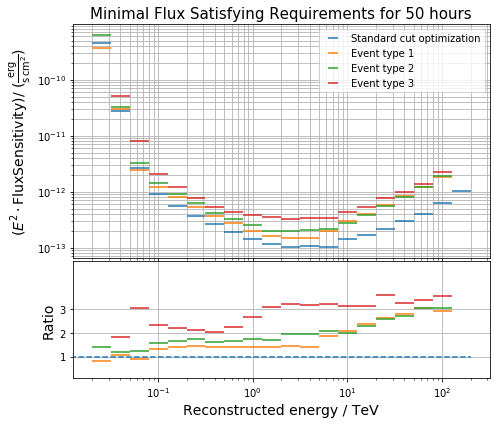

In [31]:
# Get data from event display file
e = sensitivity_alltypes['reco_energy_center']
w = (sensitivity_alltypes['reco_energy_high'] - sensitivity_alltypes['reco_energy_low'])
s = (e**2 * sensitivity_alltypes['flux_sensitivity'])

fig, (ax_sens, ax_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True, figsize=(7,6)
)

ax_sens.errorbar(
    e.to_value(u.TeV),
    s.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label="Standard cut optimization"
)

unit = u.Unit('erg cm-2 s-1')

def plot_sensitivity(sensitivity, axis, axis_ratio, label, color, ref_y):
    
    ee = sensitivity['reco_energy_center']
    ww = (sensitivity['reco_energy_high'] - sensitivity['reco_energy_low'])
    ss = (ee**2 * sensitivity['flux_sensitivity'])

    axis.errorbar(
        ee.to_value(u.TeV),
        ss.to_value(unit),
        xerr=ww.to_value(u.TeV) / 2,
        ls='',
        color=color,
        label=label
    )
    ax_ratio.errorbar(
        ee.to_value(u.TeV), ss.to_value(unit) / ref_y.to_value(unit),
        xerr=ww.to_value(u.TeV)/2,
        color=color,
        ls=''
    )
    
plot_sensitivity(sensitivity_type1, ax_sens, ax_ratio, "Event type 1", "C1", s)
plot_sensitivity(sensitivity_type2, ax_sens, ax_ratio, "Event type 2", "C2", s)
plot_sensitivity(sensitivity_type3, ax_sens, ax_ratio, "Event type 3", "C3", s)

# ax_ratio.set_yscale('log')
ax_ratio.set_xlabel("Reconstructed energy / TeV", fontsize=14)
ax_ratio.set_ylabel('Ratio', fontsize=14)
ax_ratio.grid()
ax_ratio.yaxis.set_major_formatter(ScalarFormatter())
ax_ratio.plot([0, 200], [1, 1], '--')
ax_ratio.set_ylim(0.1, 5)
ax_ratio.set_yticks([1, 2, 3])
# ax_ratio.set_yticks([], minor=True)

# Style settings
ax_sens.set_title('Minimal Flux Satisfying Requirements for 50 hours', fontsize=15)
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})", fontsize=14)

ax_sens.grid(which="both")
ax_sens.legend()
fig.tight_layout(h_pad=0)

fig.savefig("cta-s-threshold_sensitivities.pdf")

None # to remove clutter by mpl objects

## IRFs
[back to top](#Table-of-contents)

### Effective area
[back to top](#Table-of-contents)

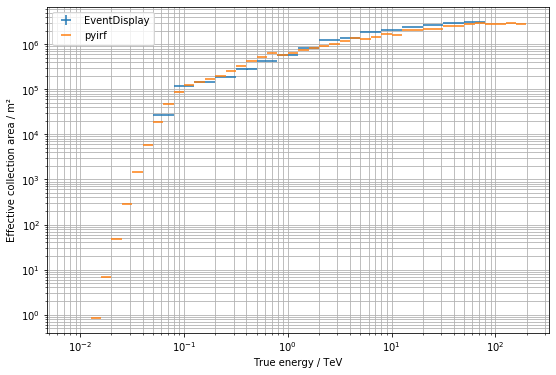

In [14]:

# Data from EventDisplay
y, edges = irf_eventdisplay["EffectiveAreaEtrue"].to_numpy()
yerr = irf_eventdisplay["EffectiveAreaEtrue"].errors()

x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

# uncomment the other strings to see effective areas
# for the different cut levels. Left out here for better
# visibility of the final effective areas.

def plot_effective_area(pyirf_file, label):

    area = QTable.read(pyirf_file, hdu='EFFECTIVE_AREA')[0]

    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label=label,
    )

plot_effective_area(my_pyirf_file, 'pyirf')    
    
# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

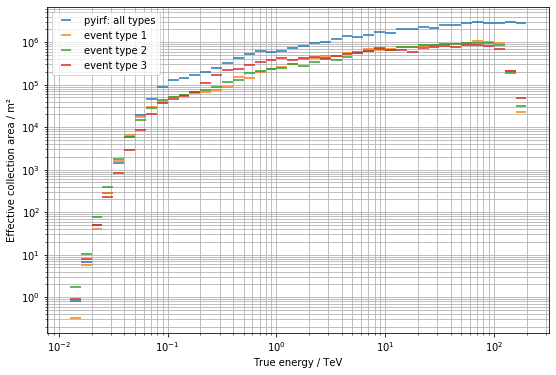

In [15]:

# Data from EventDisplay
area = QTable.read(my_pyirf_file, hdu='EFFECTIVE_AREA')[0]
y = area['EFFAREA'].to_value(u.m**2).T[1:-1, 0]
x = 0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1]
xerr = 0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1]

plt.errorbar(x, y, xerr=xerr, ls='', label="pyirf: all types")

# uncomment the other strings to see effective areas
# for the different cut levels. Left out here for better
# visibility of the final effective areas.

def plot_effective_area(pyirf_file, label):
    area = QTable.read(pyirf_file, hdu='EFFECTIVE_AREA')[0]

    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label=label,
    )
plot_effective_area(pyirf_file_event_type_1, "event type 1")
plot_effective_area(pyirf_file_event_type_2, "event type 2")
plot_effective_area(pyirf_file_event_type_3, "event type 3")
# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

### Point Spread Function
[back to top](#Table-of-contents)

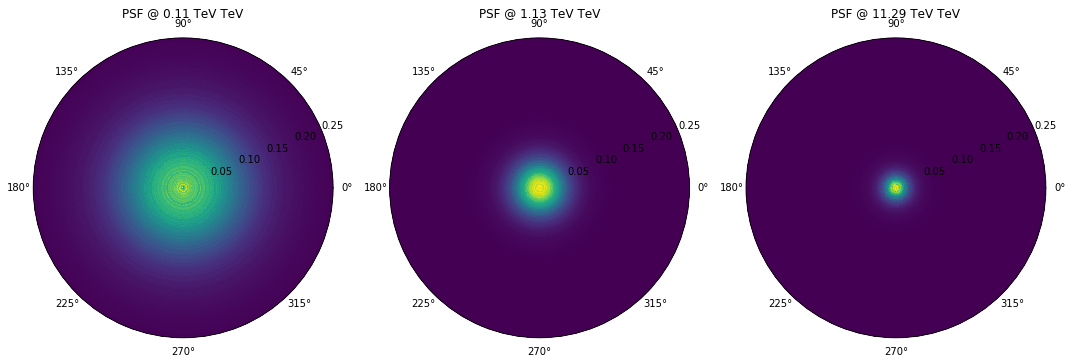

In [16]:
psf_table = QTable.read(pyirf_file_event_type_1, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)



# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))
    
    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)
    
fig.tight_layout()

None # to remove clutter by mpl objects

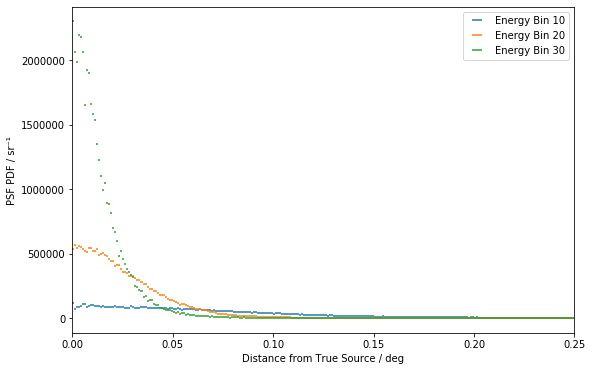

In [17]:
# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF / sr⁻¹')
plt.xlabel('Distance from True Source / deg')

None # to remove clutter by mpl objects

#### Angular resolution
[back to top](#Table-of-contents)

/home/thassan/Paquetes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


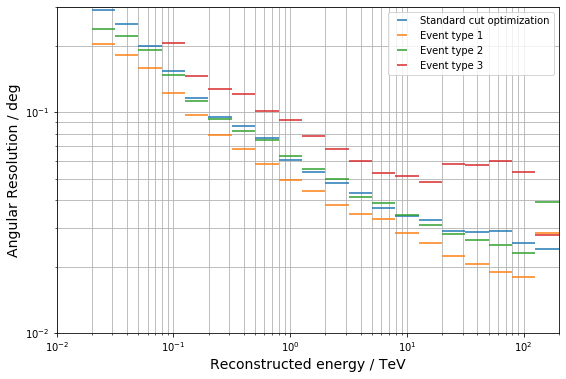

In [23]:
# Data from EventDisplay
ang_res = QTable.read(my_pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]
y = ang_res['angular_resolution'].to_value(u.deg)

x = 0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV)
xerr = 0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV)

plt.errorbar(x, y, xerr=xerr, ls='', label="Standard cut optimization")

# pyirf
def plot_ang_res(pyirf_file, label):
    ang_res = QTable.read(pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]

    plt.errorbar(
        0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV),
        ang_res['angular_resolution'].to_value(u.deg),
        xerr=0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV),
        ls='',
        label=label
    )
    
plot_ang_res(pyirf_file_event_type_1, "Event type 1")
plot_ang_res(pyirf_file_event_type_2, "Event type 2")
plot_ang_res(pyirf_file_event_type_3, "Event type 3")

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(1.e-2, 0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy / TeV", fontsize=14)
plt.ylabel("Angular Resolution / deg", fontsize=14)
plt.grid(which="both")
plt.legend(loc="best")
fig.show()
# fig.savefig("cta-s-threshold_ang_res.pdf")

None # to remove clutter by mpl objects

/home/thassan/Paquetes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


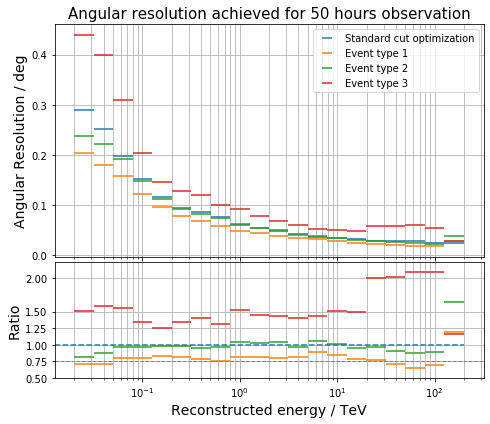

In [30]:
# Data from EventDisplay
ang_res = QTable.read(my_pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]
y = ang_res['angular_resolution'].to_value(u.deg)

x = 0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV)
xerr = 0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV)

fig, (axs, axs_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True,
    figsize=[7,6]
)


axs.errorbar(x, y, xerr=xerr, ls='', label="Standard cut optimization")

# pyirf
def plot_ang_res(pyirf_file, axis, axis_ratio, label, color, y_ref):
    ang_res = QTable.read(pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]

    axis.errorbar(
        0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV),
        ang_res['angular_resolution'].to_value(u.deg),
        xerr=0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV),
        ls='',
        label=label
    )
    axis_ratio.errorbar(
        0.5 * (ang_res['reco_energy_low'] + ang_res['reco_energy_high']).to_value(u.TeV),
        ang_res['angular_resolution'].to_value(u.deg) / y_ref,
        xerr=0.5 * (ang_res['reco_energy_high'] - ang_res['reco_energy_low']).to_value(u.TeV),
        ls='', color=color,
        label=label
    )
    
    
plot_ang_res(pyirf_file_event_type_1, axs, axs_ratio, "Event type 1", "C1", y)
plot_ang_res(pyirf_file_event_type_2, axs, axs_ratio, "Event type 2", "C2", y)
plot_ang_res(pyirf_file_event_type_3, axs, axs_ratio, "Event type 3", "C3", y)

# Style settings
# plt.xlim(1.e-2, 2.e2)
# plt.ylim(1.e-2, 0.3)
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Reconstructed energy / TeV")
# plt.ylabel("Angular Resolution / deg")
# plt.grid(which="both")
# plt.legend(loc="best")




# ax_ratio.set_yscale('log')
axs_ratio.set_xlabel("Reconstructed energy / TeV", fontsize=14)
axs_ratio.set_ylabel('Ratio', fontsize=14)
axs_ratio.grid(which="both")
axs_ratio.yaxis.set_major_formatter(ScalarFormatter())
axs_ratio.plot([0, 200], [1, 1], '--')
axs_ratio.set_ylim(0.5, 2.25)
axs_ratio.set_yticks([0.50, 0.75, 1.0, 1.25, 1.5, 2])
axs_ratio.axhline([0.75], linestyle='--', linewidth=1, color='grey') # horizontal lines
# ax_ratio.set_yticks([], minor=True)

# Style settings
axs.set_title('Angular resolution achieved for 50 hours observation', fontsize=15)
axs.set_xscale("log")
# axs.set_yscale("log")
axs.set_ylabel("Angular Resolution / deg", fontsize=14)
axs.set_xlabel("")
axs.grid(which="both")
axs.legend()
fig.tight_layout(h_pad=0)

fig.show()
fig.savefig("cta-s-threshold_ang_res.pdf")

None # to remove clutter by mpl objects

### Energy dispersion
[back to top](#Table-of-contents)

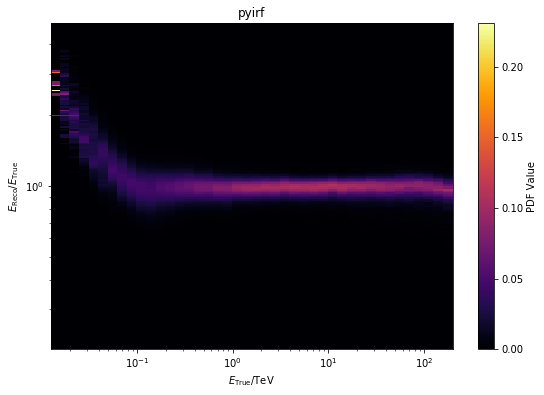

In [20]:
edisp = QTable.read(my_pyirf_file, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title('pyirf')
plt.pcolormesh(e_bins.to_value(u.TeV), migra_bins, edisp['MATRIX'].T[1:-1, 1:-1, 0].T, cmap='inferno')

plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='PDF Value')

plt.xlabel(r'$E_\mathrm{True} / \mathrm{TeV}$')
plt.ylabel(r'$E_\mathrm{Reco} / E_\mathrm{True}$')

None # to remove clutter by mpl objects

#### Energy resolution
[back to top](#Table-of-contents)

/home/thassan/Paquetes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


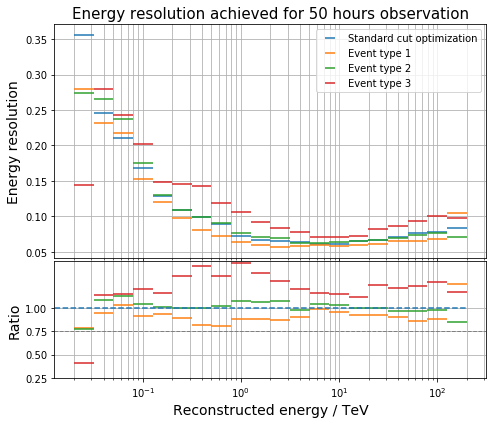

In [32]:
# Data from EventDisplay
# y, edges = irf_eventdisplay["ERes"].to_numpy()
# yerr = irf_eventdisplay["ERes"].errors()
# x = bin_center(10**edges)
# xerr = np.diff(10**edges) / 2
# plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

fig, (axs, axs_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True,
    figsize=[7,6]
)

bias_resolution = QTable.read(my_pyirf_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]
y = bias_resolution['resolution']
x = 0.5 * (bias_resolution['reco_energy_low'] + bias_resolution['reco_energy_high']).to_value(u.TeV)
xerr = 0.5 * (bias_resolution['reco_energy_high'] - bias_resolution['reco_energy_low']).to_value(u.TeV)
axs.errorbar(x, y, xerr=xerr, ls='', label="Standard cut optimization")




def plot_energy_resolution(pyirf_file, label, axis, axis_ratio, color, y_ref):
    # Data from pyirf
    bias_resolution = QTable.read(pyirf_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]

    # Plot function
    axis.errorbar(
        0.5 * (bias_resolution['reco_energy_low'] + bias_resolution['reco_energy_high']).to_value(u.TeV),
        bias_resolution['resolution'],
        xerr=0.5 * (bias_resolution['reco_energy_high'] - bias_resolution['reco_energy_low']).to_value(u.TeV),
        ls='',
        label=label
    )
    axis_ratio.errorbar(
        0.5 * (bias_resolution['reco_energy_low'] + bias_resolution['reco_energy_high']).to_value(u.TeV),
        bias_resolution['resolution'] / y_ref,
        xerr=0.5 * (bias_resolution['reco_energy_high'] - bias_resolution['reco_energy_low']).to_value(u.TeV),
        ls='', color=color,
        label=label
    )
    
    
plot_energy_resolution(pyirf_file_event_type_1, "Event type 1", axs, axs_ratio, "C1", y)
plot_energy_resolution(pyirf_file_event_type_2, "Event type 2", axs, axs_ratio, "C2", y)
plot_energy_resolution(pyirf_file_event_type_3, "Event type 3", axs, axs_ratio, "C3", y)



# # plt.yscale('log')
# plt.xscale('log')

# # Style settings
# plt.xlabel(r"$E_\mathrm{reco} / \mathrm{TeV}$")
# plt.ylabel("Energy resolution")
# plt.grid(which="both")
# plt.legend(loc="best")

# ax_ratio.set_yscale('log')
axs_ratio.set_xlabel("Reconstructed energy / TeV", fontsize=14)
axs_ratio.set_ylabel('Ratio', fontsize=14)
axs_ratio.grid(which="both")
axs_ratio.yaxis.set_major_formatter(ScalarFormatter())
axs_ratio.plot([0, 200], [1, 1], '--')
axs_ratio.set_ylim(0.5, 1.5)
# axs_ratio.set_xlim(0.03, 130)
axs_ratio.set_yticks([0.25, 0.50, 0.75, 1.0])
axs_ratio.axhline([0.75], linestyle='--', linewidth=1, color='grey') # horizontal lines
# ax_ratio.set_yticks([], minor=True)

# Style settings
axs.set_title('Energy resolution achieved for 50 hours observation', fontsize=15)
axs.set_xscale("log")
# axs.set_yscale("log")
axs.set_ylabel(r"Energy resolution", fontsize=14)
axs.set_xlabel("")
axs.grid(which="both")
axs.legend()
fig.tight_layout(h_pad=0)
fig.show()
fig.savefig("cta-s-threshold_e_res.pdf")

None # to remove clutter by mpl objects

### Background rate
[back to top](#Table-of-contents)

/home/thassan/Paquetes/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


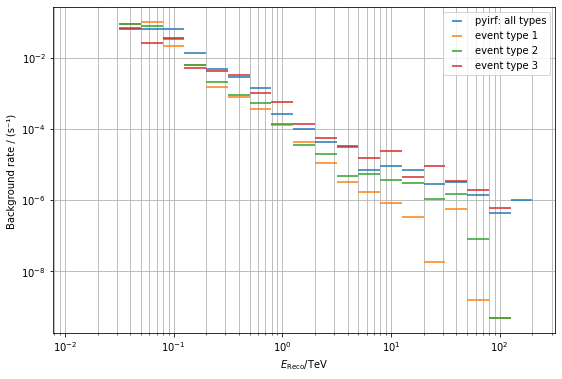

In [22]:
from pyirf.utils import cone_solid_angle

# Data from EventDisplay
# y, edges = irf_eventdisplay["BGRate"].to_numpy()
# yerr = irf_eventdisplay["BGRate"].errors()
# x = bin_center(10**edges)
# xerr = np.diff(10**edges) / 2

bg_rate = QTable.read(my_pyirf_file, hdu='BACKGROUND')[0]
reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

rad_max = QTable.read(my_pyirf_file, hdu='RAD_MAX')[0]

# first fov bin, [0, 1] deg
fov_bin = 0
rate_bin = bg_rate['BKG'].T[:, fov_bin]

# interpolate theta cut for given e reco bin
e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

# undo normalization
rate_bin *= cone_solid_angle(theta_cut)
rate_bin *= np.diff(reco_bins)

plt.errorbar(
    0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
    rate_bin.to_value(1 / u.s)[1:-1],
    xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
    ls='',
    label="pyirf: all types",
)

def plot_bg_rate(pyirf_file, label):
    bg_rate = QTable.read(pyirf_file, hdu='BACKGROUND')[0]

    reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

    # first fov bin, [0, 1] deg
    fov_bin = 0
    rate_bin = bg_rate['BKG'].T[:, fov_bin]

    # interpolate theta cut for given e reco bin
    e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
    e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
    theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

    # undo normalization
    rate_bin *= cone_solid_angle(theta_cut)
    rate_bin *= np.diff(reco_bins)

    plt.errorbar(
        0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
        rate_bin.to_value(1 / u.s)[1:-1],
        xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
        ls='',
        label=label,
    )
   
plot_bg_rate(pyirf_file_event_type_1, "event type 1")
plot_bg_rate(pyirf_file_event_type_2, "event type 2")
plot_bg_rate(pyirf_file_event_type_3, "event type 3")

# Style settings
plt.xscale("log")
plt.xlabel(r"$E_\mathrm{Reco} / \mathrm{TeV}$")
plt.ylabel("Background rate / (s⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.yscale('log')

None # to remove clutter by mpl objects